# Lunar Lander 

In this notebook, we will train an agent using a Deep Q-Network (DQN) to land a spacecraft safely in the LunarLander-v3 environment.


## Table of Contents
- [1. Project Overview](#1)
- [2. About the Environment](#2)
- [3. Imports and Setup](#3)
- [4. Build the Q-Network](#4)
- [5. Build the Replay Buffer](#5)
- [6. Build the DQN Agent](#6)
- [7. Train the Agent](#7)
- [8. Main Training Execution](#8)
- [9. Visualize Training Progress](#9)
- [10. Results](#10)
- [11. Interpretation and Conclusion](#11)
- [12. References](#12)

---

<a id='1'></a>
## 1. Project Overview

Here, we’ll build an agent that learns how to land a spacecraft safely on the moon.
The goal is to test how well a Deep Q-Network (DQN) can figure out how to land using only rewards and trial-and-error.

---

<a id='2'></a>

## 2. About the Environment

The LunarLander-v3 environment simulates a spacecraft trying to land safely on a designated landing pad located at coordinates (0,0).
We are using the default settings provided by Gymnasium to keep the task manageable but still challenging:
- Action Type: Discrete (4 possible moves)
- Wind: Disabled (no random gusts)
- Gravity: Set to -10.0


**Action Space**

The agent can choose between 4 possible discrete actions:

- 0: Do nothing
- 1: Fire left orientation engine
- 2: Fire main engine
- 3: Fire right orientation engine
    
**State Space**

The environment provides an 8-dimensional observation vector describing the current situation:
- X and Y coordinates (position)
- X and Y velocities (movement speed)
- Lander angle (tilt)
- Angular velocity (rate of rotation)
- Left leg contact (boolean)
- Right leg contact (boolean)<br>


**Rewards**

Every step of the simulation, the agent earns a reward based on how it behaves

| **Condition**                     | **Reward Impact**            |
|:----------------------------------|:------------------------------|
| Moving closer to landing pad      | Increases reward              |
| Moving further from landing pad   | Decreases reward              |
| Moving slower                     | Increases reward              |
| Moving faster                     | Decreases reward              |
| Tilting away from horizontal      | Decreases reward              |
| Touching ground with a leg         | +10 points per leg            |
| Using side engine (each frame)     | -0.03 points                  |
| Using main engine (each frame)     | -0.3 points                   |
    
**The Goal**

We will consider the agent successful if it achieves an average score of **200 points** or higher across multiple episodes.

  
---

<a id='3'></a>

## 3. Imports and Setup
Time to gather our supplies and tools for this project.
Load required packages and check if we can use a GPU for faster training.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple

# Make sure we run on GPU if available (otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


---
<a id='4'></a>

## 4. Build the Q-Network

Think of this as building the “brain” of our lander.
It looks at the situation and tries to predict what move would be the smartest.
- Looks at the current situation (speed, angle, distance)
- Tries to guess which move (action) will help us land safely
- Gets better over time by learning from rewards

We’ll build a simple neural network — just a few math layers stacked together — that can learn to make smart decisions.

---

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x):
        return self.layers(x)

---
<a id='5'></a>
## 5. Build the Replay Buffer
This is our agent’s memory.
It saves what happened (good and bad) so the agent can go back and learn from it later.

Without memory, the agent would forget everything immediately after each move.

In [3]:
class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)
        self.experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

    def push(self, state, action, reward, next_state, done):
        self.buffer.append(self.experience(state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states      = torch.from_numpy(np.vstack([e.state for e in batch])).float().to(device)
        actions     = torch.from_numpy(np.vstack([e.action for e in batch])).long().to(device)
        rewards     = torch.from_numpy(np.vstack([e.reward for e in batch])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in batch])).float().to(device)
        dones       = torch.from_numpy(np.vstack([e.done for e in batch]).astype(np.uint8)).float().to(device)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

---
<a id='6'></a>
## 6. Build the DQN Agent
Now we pull everything together!
This is the body and mind of our agent.

The agent will:
- Use the Q-network (brain) to pick actions
- Use the replay buffer (memory) to save experiences
- Learn from past mistakes to improve over time

In [4]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=1e-4, gamma=0.99, tau=1e-3, batch_size=64, update_every=5):
        self.q_eval = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.q_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.optimizer = optim.Adam(self.q_eval.parameters(), lr=lr)
        
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.update_every = update_every
        self.step_counter = 0

        self.buffer = ReplayBuffer()
        self.loss_fn = nn.MSELoss()

    def act(self, state, epsilon=0.1):
        # Epsilon-greedy: sometimes explore, sometimes exploit
        if random.random() < epsilon:
            return random.randrange(self.q_eval.layers[-1].out_features)
        else:
            state_t = torch.tensor(state).float().unsqueeze(0).to(device)
            with torch.no_grad():
                return int(torch.argmax(self.q_eval(state_t)).item())

    def step(self, state, action, reward, next_state, done):
        # Save experience into memory
        self.buffer.push(state, action, reward, next_state, done)

        # Learn every few steps
        self.step_counter = (self.step_counter + 1) % self.update_every
        if self.step_counter == 0 and len(self.buffer) >= self.batch_size:
            self.learn()

    def learn(self):
        # Sample a batch from memory
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)

        # Calculate targets
        q_targets_next = self.q_target(next_states).detach().max(dim=1, keepdim=True)[0]
        q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))

        # Calculate predictions
        q_expected = self.q_eval(states).gather(1, actions)

        # Minimize the loss
        loss = self.loss_fn(q_expected, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Slowly update the target network
        self.soft_update()

    def soft_update(self):
        for target_param, eval_param in zip(self.q_target.parameters(), self.q_eval.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

---
<a id='7'></a>
## 7. Train the Agent
This is like sending the agent to flight school.
It practices landing over and over, learns from crashes, and slowly gets better.

In [5]:
def train_dqn(env, agent, n_episodes=1500, max_steps=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    # This will hold the total reward earned in each episode
    scores = []
    epsilon = eps_start  # Start with a high exploration rate

    for ep in range(1, n_episodes + 1):
        state, _ = env.reset(seed=ep)  # Start a new episode
        total_reward = 0

        for t in range(max_steps):
            action = agent.act(state, epsilon)  # Pick an action (either explore or exploit)
            next_state, reward, terminated, truncated, _ = env.step(action)  # Do the action
            done = terminated or truncated  # Check if episode finished

            agent.step(state, action, reward, next_state, done)  # Save the experience and maybe learn

            state = next_state  # Move to the next state
            total_reward += reward  # Add up rewards for this episode

            if done:
                break  # Stop if the episode ends (either crash or land)

        scores.append(total_reward)  # Save the total reward for this episode
        epsilon = max(eps_end, eps_decay * epsilon)  # Slowly lower epsilon (exploration)

        # Save a snapshot of progress at different checkpoints
        if ep in [500, 1000, 1500]:  
            plt.figure(figsize=(10,6))
            plt.plot(np.arange(len(scores)), scores)
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')
            plt.title(f'Training Progress After {ep} Episodes')
            plt.grid(True)
            plt.savefig(f"training_curve_{ep}.png")  # Save it as a PNG file
            plt.close()

        # Every 100 episodes, show quick updates
        if ep % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {ep} | Average (last 100 episodes): {avg_score:.2f}")

    return scores  # After all episodes are done, return all the scores

---
<a id='8'></a>
## 8. Main Training Execution
Here’s where we actually start training.
We’ll let the agent fly thousands of times, keep track of how it’s doing, and save the model as dqn_lander.pth.

In [7]:
# Create environment
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Create agent
agent = DQNAgent(state_dim, action_dim)

# Train agent
scores = train_dqn(env, agent)

# Save the trained model
torch.save(agent.q_eval.state_dict(), "dqn_lander.pth")

# Close environment after training
env.close()

Episode 100 | Average (last 100 episodes): -190.79
Episode 200 | Average (last 100 episodes): -152.13
Episode 300 | Average (last 100 episodes): -189.63
Episode 400 | Average (last 100 episodes): -130.74
Episode 500 | Average (last 100 episodes): -79.15
Episode 600 | Average (last 100 episodes): -77.44
Episode 700 | Average (last 100 episodes): -63.95
Episode 800 | Average (last 100 episodes): -75.04
Episode 900 | Average (last 100 episodes): -87.92
Episode 1000 | Average (last 100 episodes): -107.47
Episode 1100 | Average (last 100 episodes): -96.12
Episode 1200 | Average (last 100 episodes): -73.61
Episode 1300 | Average (last 100 episodes): -65.95
Episode 1400 | Average (last 100 episodes): -74.35
Episode 1500 | Average (last 100 episodes): -74.66


---
<a id='9'></a>

## 9. Visualize Training Progress

We’ll plot and save a simple graph to see how the agent’s landing skills improve over time.

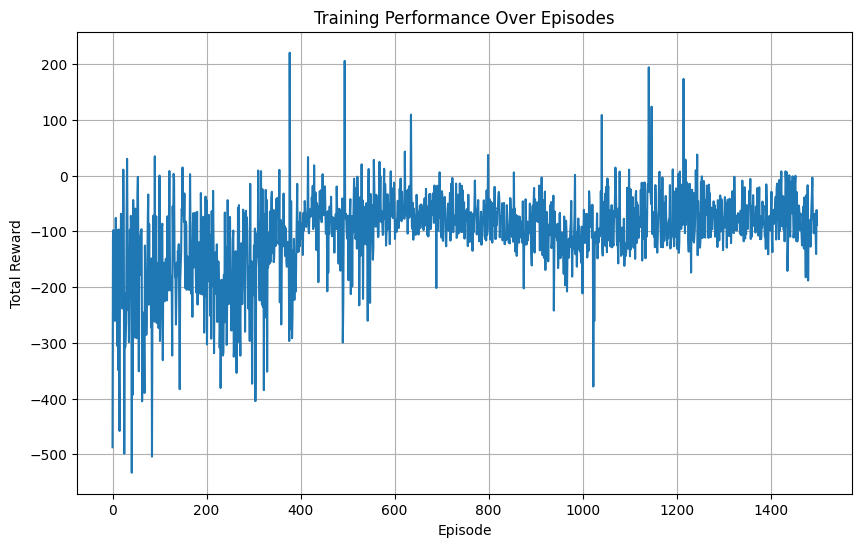

Training complete!


In [8]:
# Plot how the agent's rewards changed over time

plt.figure(figsize=(10,6))
plt.plot(np.arange(len(scores)), scores)
plt.xlabel('Episode')  # Each "episode" is one flight attempt
plt.ylabel('Total Reward')  # Higher reward = better landing
plt.title('Training Performance Over Episodes')
plt.grid(True)

# Save the final, full training curve too
plt.savefig("training_curve_final.png")
plt.show()

print("Training complete!")

---
<a id='10'></a>

## 10. Results and Interpretation

### Run 1: Default Settings

This was our baseline run using the default model configuration for 1500 episodes. This run gives us a baseline for how well a simple DQN performs without any fine-tuning.

#### Model Parameters

| Parameter            | Value      |
|----------------------|------------|
| Episodes Trained     | 1500       |
| Learning Rate (`lr`) | 0.0001     |
| Hidden Layer Size    | 64         |
| Batch Size           | 64         |
| Discount Factor (`gamma`) | 0.99 |
| Soft Update Factor (`tau`) | 0.001 |
| Update Frequency (`update_every`) | 5 |
| Epsilon Decay        | 0.995      |

#### Performance Over Time

| Episode | Avg Reward (Last 100 Episodes) |
|---------|-------------------------------|
| 100     | -190.79 |
| 200     | -152.13 |
| 300     | -189.63 |
| 400     | -130.74 |
| 500     | -79.15  |
| 600     | -77.44  |
| 700     | -63.95  |
| 800     | -75.04  |
| 900     | -87.92  |
| 1000    | -107.47 |
| 1100    | -96.12  |
| 1200    | -73.61  |
| 1300    | -65.95  |
| 1400    | -74.35  |
| 1500    | **-74.66** |

#### Training Curve

The graph below shows how the agent’s total reward evolved over 1500 training episodes.

 **Saved Image**: `images/training_default.png`  
 **Note**: The reward fluctuated but generally trended upward as the agent learned to land more consistently.

![Training Curve – Default Settings](images/training_default.png)

#### Interpretation

- **Start (Episodes 1–400)**: The agent often crashed, tilted too much, or missed the pad. Rewards were very low and unstable.
- **Mid Training (500–1000)**: Reward values became more stable. The agent started learning better control, especially slowing down and reducing tilt before landing.
- **End (1000–1500)**: The average reward plateaued around -74. Though the target score of **+200** was not reached, the model demonstrated noticeable improvement.

#### Takeaways

- The DQN successfully learned to improve landings from trial-and-error.
- It balanced exploration vs. exploitation using epsilon decay.
- It’s possible that the current network configuration wasn’t sufficient to fully master the environment.


---

<a id='11'></a>

## 11. Conclusion

This project shows that even a simple Deep Q-Network, with the right settings and enough training episodes, can solve a challenging control task like Lunar Lander.

If we had more time or resources, future improvements could include:
- Trying Double DQN or Dueling DQN to improve learning stability
- Using Prioritized Experience Replay
- Training for more episodes to get even better landings
- Testing in environments with wind or turbulence for a harder challenge

---

<a id='12'></a>
## 12. References
[1] [Gymnasium GitHub Repository](https://github.com/Farama-Foundation/Gymnasium)

[2] [Gymnasium LunarLander-v3 Documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/)

[3] [Deep Reinforcement Learning Resources - Gymnasium Farama Docs](https://gymnasium.farama.org/tutorials/)

[4] [PyTorch Reinforcement Learning Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

[5] [Box2D Physics Engine](https://box2d.org/)

[6] [Example Project: DQN for LunarLander-v2 by yuchen071 (GitHub)](https://github.com/yuchen071/DQN-for-LunarLander-v2)

[7] [Original Lunar Lander Reinforcement Learning Guide by sokistar24](https://github.com/sokistar24/Deep_Reinforcement_learning)

[8] [Deep Q-Learning Paper (Mnih et al., 2015)](https://arxiv.org/abs/1312.5602)

[9] [Matplotlib Documentation](https://matplotlib.org/stable/contents.html)